## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import os
import deepxde as dde
from utils.gs_solovev_sol import GS_Linear


######################
# ITER Configuration #
######################
A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse(eps, kappa, delta) 

x,u = gen_traindata(1001)

n_test = 100

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - delta * eps, kappa * eps],
                        [1 - delta * eps, -kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

observe_x = np.concatenate((x,observe_x))
observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=1024,
    num_boundary=0,
    num_test=n_test,
    train_distribution="LHS"
)

# net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

# model = dde.Model(data, net)


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



Text(0, 0.5, '$u(r,z=0)$')

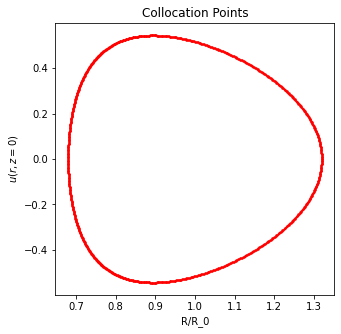

In [2]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

## Train Model

Compiling model...
Building feed-forward neural network...


/Users/alankaptanoglu/deepxde_copy/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'build' took 0.531524 s

'compile' took 19.713547 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.05e+00, 1.74e-01]    [1.05e+00, 1.74e-01]    []  
1         [1.14e+00, 1.57e+00]    [1.15e+00, 1.57e+00]    []  
2         [1.05e+00, 1.41e-01]    [1.05e+00, 1.41e-01]    []  
3         [9.71e-01, 1.22e-01]    [9.78e-01, 1.22e-01]    []  
4         [9.29e-01, 4.08e-01]    [9.36e-01, 4.08e-01]    []  
5         [9.21e-01, 2.68e-01]    [9.29e-01, 2.68e-01]    []  
6         [9.29e-01, 3.85e-02]    [9.37e-01, 3.85e-02]    []  
7         [9.34e-01, 5.48e-02]    [9.42e-01, 5.48e-02]    []  
8         [9.16e-01, 1.89e-01]    [9.24e-01, 1.89e-01]    []  
9         [8.72e-01, 1.44e-01]    [8.81e-01, 1.44e-01]    []  
10        [8.10e-01, 2.47e-02]    [8.20e-01, 2.47e-02]    []  
11        [7.34e-01, 3.63e-02]    [7.45e-01, 3.63e-02]    []  
12        [6.52e-01, 1.59e-01]    [6.63e-01, 1.59e-01]    []  
13        [5.

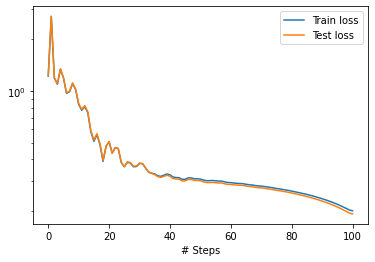

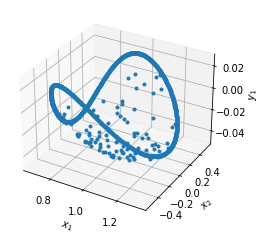

Accuracy
Mean residual: 0.45356962


In [3]:
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DROPOUT = 0.1
DEPTH = 3
BREADTH = 20
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"
PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"

# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], AF, "Glorot normal",
    #dropout_rate=DROPOUT
)

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,100]
  )
  loss_history, train_state = model.train(
      epochs=100, display_every=1, #callbacks=[dde.callbacks.DropoutUncertainty()]
  )
  dde.saveplot(
      loss_history, 
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

## Plotting

#### Before BFGS

[[ 5.92465121  5.69551292  5.47413496 ... 10.63546062 12.76716532
  15.20161934]
 [ 4.94648485  4.7491155   4.55932738 ...  9.81128957 11.77534837
  14.02031869]
 [ 4.07760788  3.90913729  3.74798712 ...  9.03994339 10.84757444
  12.91569947]
 ...
 [ 0.47129525  0.48327002  0.49898229 ...  0.14300804  0.31017348
   0.56007744]
 [ 0.80797398  0.8226861   0.8420261  ...  0.11802453  0.28149549
   0.53362946]
 [ 1.26412984  1.28120853  1.30378875 ...  0.09408789  0.25246248
   0.50601386]]
[[ 5.92465121  5.69551292  5.47413496 ... 10.63546062 12.76716532
  15.20161934]
 [ 4.94648485  4.7491155   4.55932738 ...  9.81128957 11.77534837
  14.02031869]
 [ 4.07760788  3.90913729  3.74798712 ...  9.03994339 10.84757444
  12.91569947]
 ...
 [ 0.47129525  0.48327002  0.49898229 ...  0.14300804  0.31017348
   0.56007744]
 [ 0.80797398  0.8226861   0.8420261  ...  0.11802453  0.28149549
   0.53362946]
 [ 1.26412984  1.28120853  1.30378875 ...  0.09408789  0.25246248
   0.50601386]]


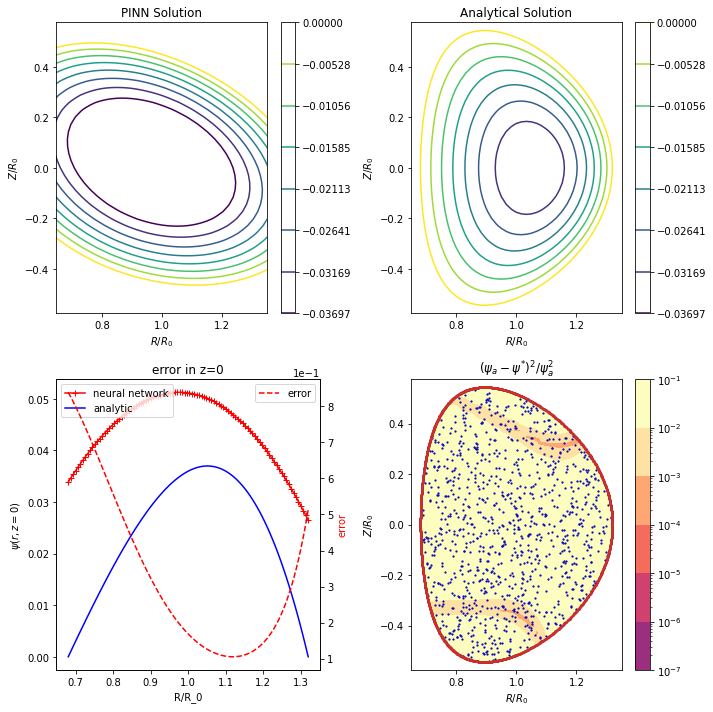

In [4]:
# Evaluation
from utils.utils import *
ITER = GS_Linear(eps=0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test, PATH)

#### After BFGS

Compiling model...
'compile' took 16.861392 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.57e-01, 4.39e-02]    [1.49e-01, 4.39e-02]    []  
110       [1.41e-01, 4.06e-02]    [1.41e-01, 4.06e-02]        
120       [6.41e-02, 1.92e-02]    [6.41e-02, 1.92e-02]        
130       [1.97e-02, 5.99e-03]    [1.97e-02, 5.99e-03]        
140       [7.69e-04, 4.98e-03]    [7.69e-04, 4.98e-03]        
150       [3.47e-04, 3.29e-03]    [3.47e-04, 3.29e-03]        
160       [4.37e-04, 1.56e-03]    [4.37e-04, 1.56e-03]        
170       [1.92e-04, 8.26e-04]    [1.92e-04, 8.26e-04]        
180       [2.57e-04, 5.72e-04]    [2.57e-04, 5.72e-04]        
190       [2.82e-04, 4.95e-04]    [2.82e-04, 4.95e-04]        
200       [1.26e-04, 1.84e-04]    [1.26e-04, 1.84e-04]        
210       [5.55e-05, 3.75e-05]    [5.55e-05, 3.75e-05]        
220       [5.19e-05, 2.11e-05]    [5.19e-05, 2.11e-05]        
230       [2.78e-05, 1.82e-05]    [2.78e-05, 

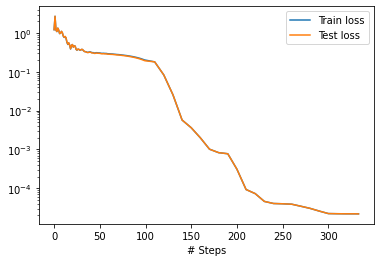

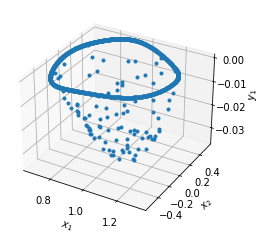

In [5]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(
    epochs=1000, display_every=10, #callbacks=[dde.callbacks.DropoutUncertainty()]
)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)

[[0.01124036 0.00904461 0.00707838 ... 0.02721926 0.03717788 0.0494683 ]
 [0.01013446 0.00828552 0.00661215 ... 0.027046   0.03604172 0.04700714]
 [0.00895794 0.00742814 0.00602955 ... 0.02613842 0.03411896 0.04374642]
 ...
 [0.01183695 0.0096238  0.0076669  ... 0.03855827 0.04924654 0.06200636]
 [0.01374918 0.01106074 0.00869874 ... 0.04220056 0.05460706 0.0695164 ]
 [0.01573576 0.0125138  0.00970258 ... 0.04528616 0.05947627 0.07665078]]
[[0.01124036 0.00904461 0.00707838 ... 0.02721926 0.03717788 0.0494683 ]
 [0.01013446 0.00828552 0.00661215 ... 0.027046   0.03604172 0.04700714]
 [0.00895794 0.00742814 0.00602955 ... 0.02613842 0.03411896 0.04374642]
 ...
 [0.01183695 0.0096238  0.0076669  ... 0.03855827 0.04924654 0.06200636]
 [0.01374918 0.01106074 0.00869874 ... 0.04220056 0.05460706 0.0695164 ]
 [0.01573576 0.0125138  0.00970258 ... 0.04528616 0.05947627 0.07665078]]


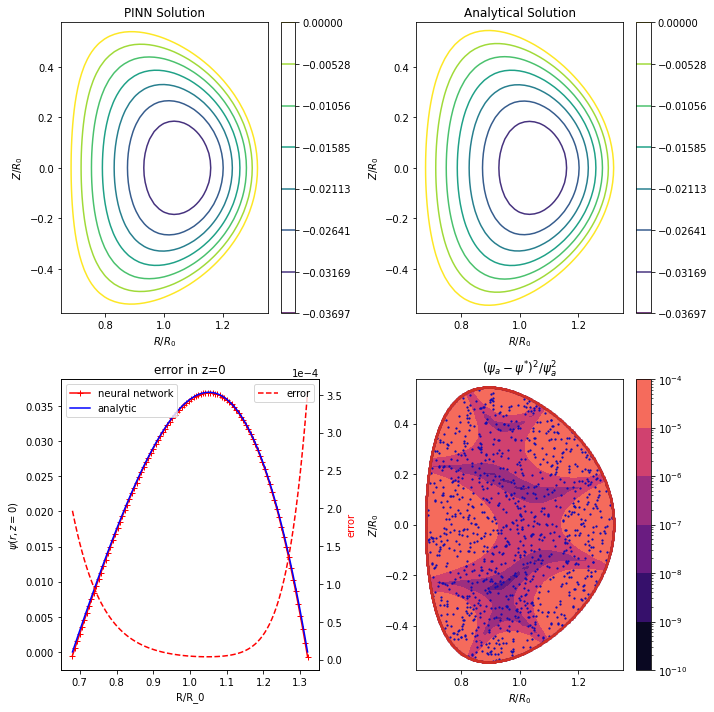

In [6]:
# Evaluation
x, y, psi_pred, psi_true, error = evaluate(ITER, model)
x_eq, psi_true_eq, psi_pred_eq, e_eq = evaluate_eq(ITER, model)
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test, PATH)

True volume =  0.538714633599034
predicted volume =  0.5389709336429152
True Cp =  2.769043083412222
predicted Cp =  2.7700623917078806
True qstar =  1.5447070451895963
True beta_p =  1.2359998633055786
True beta_t =  0.05304276133194401
True beta =  0.05086010695268426
Predicted qstar =  1.5452756649828225
Predicted beta_p =  1.2309406438345334
Predicted beta_t =  0.05278677596101803
Predicted beta =  0.050616187662138754


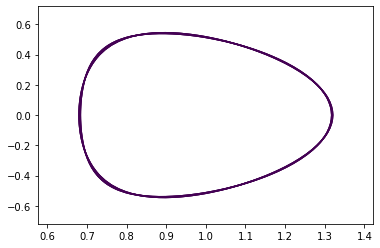

In [7]:
engineering_params = compute_params(x, y, psi_true, psi_pred)